Goal: combine SNAP data, which is monthly trends over 100 years, and DayMet, which is daily data over recent history, to form a reasonable cycle of data following the SNAP trend but with reasonable daily cycles.

In [ ]:
#%matplotlib

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import colors
import itertools

/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# short names for keys
k_T = 'air temperature [K]'
k_qSW = 'incoming shortwave radiation [W m^-2]'
k_qLW = 'incoming longwave radiation [W m^-2]'
k_Pr = 'precipitation rain [m s^-1]'
k_Ps = 'precipitation snow [m SWE s^-1]'
k_P = 'precipitation [m s^-1]'
k_RH = 'relative humidity [-]'
k_time = 'time [s]'
k_U = 'wind speed [m s^-1]'


In [3]:
def load_met(fname, cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        assert(len(_daymet[k_time][:])%cycle == 0)
        daymet_nyears = len(_daymet[k_time][:]) / cycle

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
    except KeyError:
        pass
    return daymet_nyears, daymet
  

In [4]:
nyears, daymet = load_met('../Barrow_Alaska/barrow1985-2015-trend-smooth.h5')
normalization = dict()

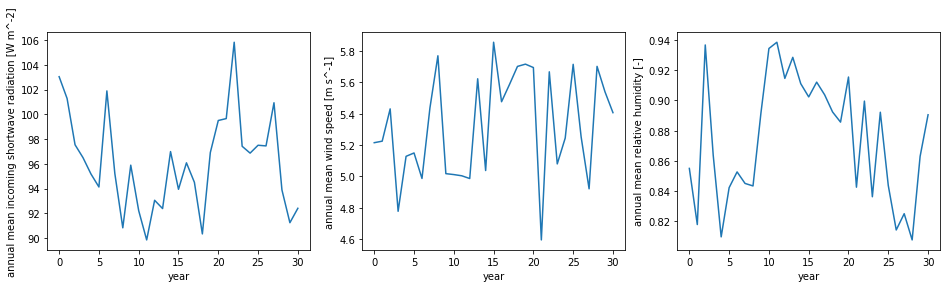

In [9]:
# check for trends in things we don't expect trends in
plt.figure(figsize=(16,4))
for i,k in enumerate([k_qSW, k_U, k_RH]):
    means = daymet[k].mean(1)
    plt.subplot(1,3,i+1)
    plt.plot(means)
    plt.ylabel('annual mean %s'%k)
    plt.xlabel('year')

plt.show()

# they look good now that wind speed has been detrended!  Look safe to use to me.
normalization[k_qSW] = daymet[k_qSW] / daymet[k_qSW].mean()
normalization[k_RH] = daymet[k_RH] - daymet[k_RH].mean()

[ 1.50001128e-10  1.30744642e-10  1.11488156e-10  9.22316707e-11
  7.29751849e-11  5.37186991e-11  3.44622133e-11  1.52057276e-11
 -4.05075822e-12 -2.33072440e-11 -4.25637298e-11 -6.18202155e-11
 -8.10767013e-11 -1.00333187e-10 -1.19589673e-10 -1.38846159e-10
  1.58102644e-10  4.29323916e-10  7.00545189e-10  9.71766461e-10
  1.24298773e-09  1.51420900e-09  1.78543028e-09  2.05665155e-09
  2.32787282e-09  2.59909409e-09  2.87031537e-09  3.14153664e-09
  3.41275791e-09  3.68397918e-09  3.95520045e-09]
[0.97066481 0.97462402 0.98184257 0.97878757 0.99002331 0.98991889
 0.98703468 0.99622546 1.00058191 1.00480029 1.01586497 1.0161122
 1.01652489 1.02104438 1.02927302 1.02174869 0.97358864 0.90893003
 0.89646862 0.85402039 0.78461753 0.73068028 0.56774564 0.69687362
 0.70504224 0.6536238  0.67787845 0.59266069 0.68646745 0.58435494
 0.45918569]
(5.113350375206907e-09, 4.963349247228497e-09)


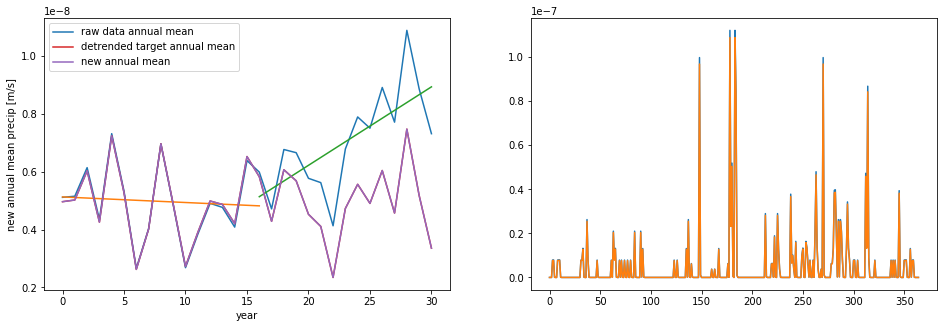

In [10]:
# do we need to detrend precip?
means = daymet[k_P].mean(1)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(means, label='raw data annual mean')
plt.ylabel('annual mean precip [m/s]')
plt.xlabel('year')

# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(np.arange(0,17), polyfit(np.arange(0,17)))

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(np.arange(nyears-15, nyears), polyfit2(np.arange(nyears-15,nyears)))

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
print(mean_shift)
plt.plot(means - mean_shift, label='detrended target annual mean')

# transform precip by scaling -- this is necessary to keep positive
# effectively this means that all changes in precip will be changes in precip intensity.  
# This is equivalent to duration over a day, i.e. we see no difference between raining
# twice as hard and raining twice as long over a given day.  But it doesn't introduce 
# more events or make it rain on days it doesn't currently rain on.
transform = (means - mean_shift) / means
print(transform)
precip = np.array([daymet[k_P][i,:]*(means[i] - mean_shift[i])/means[i] for i in range(nyears)])
new_means = precip.mean(1)

plt.plot(new_means, label='new annual mean')
plt.ylabel('new annual mean precip [m/s]')
plt.xlabel('year')
plt.legend()

plt.subplot(122)
plt.plot(daymet[k_P][0,:])
plt.plot(precip[0])
print(daymet[k_P][0,:].mean(), precip[0].mean())

plt.show()

# normalize to 1, then save
normalization[k_P] = precip / precip.mean()

[-1.5502119  -1.45888776 -1.36756362 -1.27623947 -1.18491533 -1.09359119
 -1.00226704 -0.9109429  -0.81961876 -0.72829461 -0.63697047 -0.54564633
 -0.45432218 -0.36299804 -0.2716739  -0.18034975  0.08902561  0.18776939
  0.28651316  0.38525694  0.48400072  0.58274449  0.68148827  0.78023205
  0.87897583  0.9777196   1.07646338  1.17520716  1.27395094  1.37269471
  1.47143849]


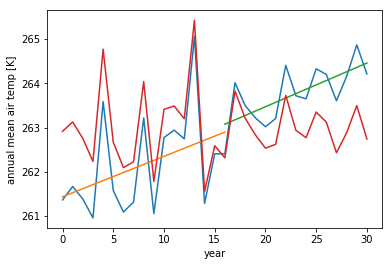

In [11]:
# do we need to detrend air temp?
means = daymet[k_T].mean(1)
plt.figure()
plt.plot(means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

# again, do with a split at the 17th year...
# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(np.arange(0,17), polyfit(np.arange(0,17)))

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(np.arange(nyears-15, nyears), polyfit2(np.arange(nyears-15,nyears)))

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
print(mean_shift)
plt.plot(means - mean_shift, label='detrended target annual mean')

plt.show()

[-1.55232995e+00 -1.44884129e+00 -1.34535262e+00 -1.24186396e+00
 -1.13837530e+00 -1.03488663e+00 -9.31397970e-01 -8.27909307e-01
 -7.24420644e-01 -6.20931980e-01 -5.17443317e-01 -4.13954653e-01
 -3.10465990e-01 -2.06977327e-01 -1.03488663e-01 -5.68434189e-14
  1.03488663e-01  2.06977327e-01  3.10465990e-01  4.13954653e-01
  5.17443317e-01  6.20931980e-01  7.24420644e-01  8.27909307e-01
  9.31397970e-01  1.03488663e+00  1.13837530e+00  1.24186396e+00
  1.34535262e+00  1.44884129e+00  1.55232995e+00]


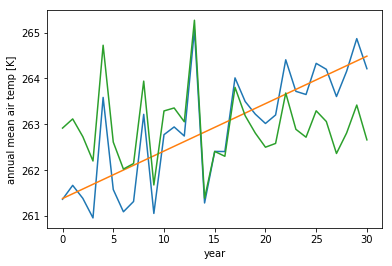

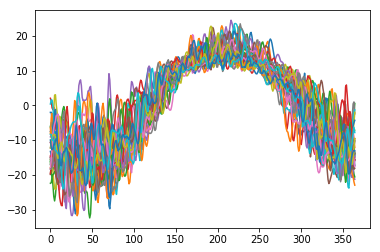

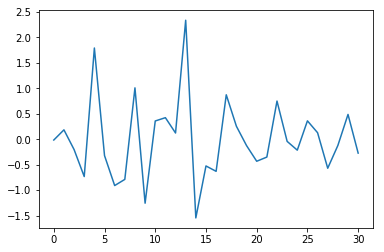

In [12]:
# actually that's just a flat line...
plt.figure()
plt.plot(means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

polyfit = np.poly1d(np.polyfit(np.arange(0,nyears), means, deg=1))
plt.plot(np.arange(0,nyears), polyfit(np.arange(0,nyears)))

# shift the means
mean_shift = polyfit(np.arange(0,nyears)) - means.mean()
print(mean_shift)
plt.plot(means - mean_shift, label='detrended target annual mean')

# shift the data
air_temp = np.array([daymet[k_T][i,:] - mean_shift[i] for i in range(nyears)])

# save normalization as zero-mean
normalization[k_T] = air_temp - air_temp.mean()

plt.figure()
for ta in normalization[k_T]:
    plt.plot(ta)

plt.figure()
plt.plot(normalization[k_T].mean(1))

plt.show()

In [13]:
# load the SNAP data
nyears_s, snap = load_met("snap-2006-2100-monthly.h5", cycle=12)
year_s = np.arange(2006, 2006+nyears_s)
year_dm = np.arange(1985, 1985+nyears)

In [14]:
# also load CESM RCP4.5 just for comparison sake
nyears_c, cesm45 = load_met("../CESM/CESM_4_5.h5", cycle=365)
year_c = np.arange(2006, 2006+nyears_c)

nyears_c85, cesm85 = load_met("../CESM/CESM_8_5.h5", cycle=365)


In [15]:
cm = colors.cm_mapper(0,3)

def plot(yr, ds, k, label, i):
    plt.plot(yr, ds[k].mean(1), label=label, color=cm(i))
    poly = np.poly1d(np.polyfit(yr, ds[k].mean(1), deg=1))
    plt.plot(yr, poly(yr), color=cm(i))
    return poly

poly_trends = dict()
for dset in ['DayMet', 'SNAP', 'CESM RCP4.5', 'CESM RCP8.5']:
    poly_trends[dset] = dict()
    
def plot_all(k):
    poly_trends['DayMet'][k] = plot(year_dm, daymet, k, 'DayMet', 0)
    poly_trends['SNAP'][k] = plot(year_s, snap, k, 'SNAP', 1)
    poly_trends['CESM RCP4.5'][k] = plot(year_c, cesm45, k, 'CESM RCP4.5', 2)
    poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3)

    plt.xlabel('year')
    plt.ylabel("annual mean %s"%k)
    plt.legend()


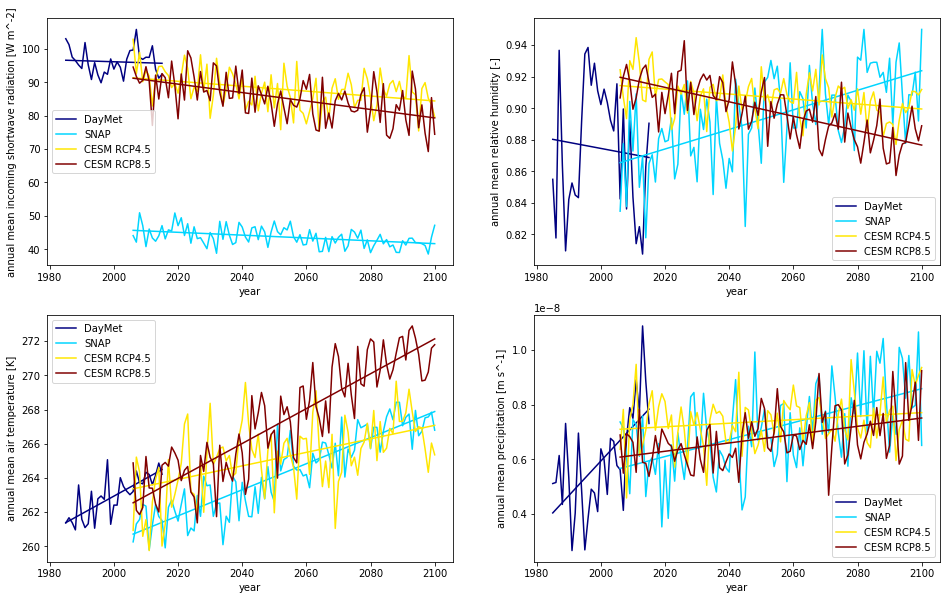

In [17]:
# check for trends
plt.figure(figsize=(16,10))
plt.subplot(221)
plot_all(k_qSW)
plt.subplot(222)
plot_all(k_RH)
plt.subplot(223)
plot_all(k_T)
plt.subplot(224)
plot_all(k_P)
plt.show()

In [25]:
# utilities
def year_generator(dat):
    for i in itertools.cycle(range(dat.shape[0])):
        yield dat[i,:]

def plot(years, precip_proj, trend_poly, k):
    plt.figure(figsize=(16,7))
    plt.plot(np.arange(years[0], years[-1]+1, 1.0/365), precip_proj.ravel())
    plt.plot(np.arange(year_dm[0], year_dm[-1]+1, 1.0/365), daymet[k].ravel())

    plt.plot(year_dm, poly_trends['DayMet'][k](year_dm))
    plt.plot(year_dm, daymet[k].mean(1))
    plt.plot(years, trend_poly(years))
    plt.plot(years, precip_proj.mean(1))
    plt.xlabel('year')
    plt.ylabel(k)
    plt.show()   
    
def project_and_plot(years, trend_poly, normalized, k, operator='additive'):
    print("Projecting: %s"%k)
    if operator == 'additive':
        precip_proj = np.array([pr + trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    elif operator == 'multiplicative':
        precip_proj = np.array([pr*trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    else:
        raise RuntimeError('invalid operator, must be "additive" or "multiplicative"')
    print(precip_proj.shape)
    plot(years, precip_proj, trend_poly, k)
    
    # check min/max are reasonable
    print(precip_proj.min(), precip_proj.max())
    return precip_proj  


In [19]:
# projected dataset
proj = dict()


Projecting: precipitation [m s^-1]
(95, 365)


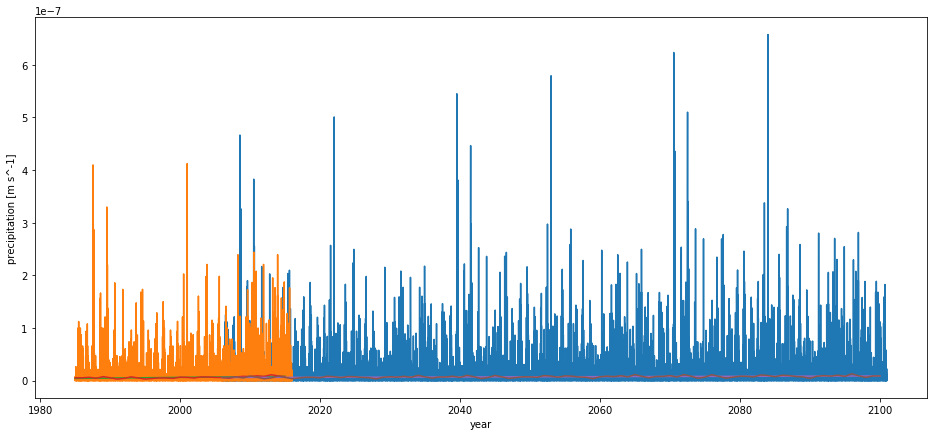

(0.0, 6.572009589819353e-07)


In [26]:
# use snap precip
proj[k_P] = project_and_plot(year_s, poly_trends['SNAP'][k_P], normalization[k_P], k_P, operator="multiplicative")

Projecting: air temperature [K]
(95, 365)


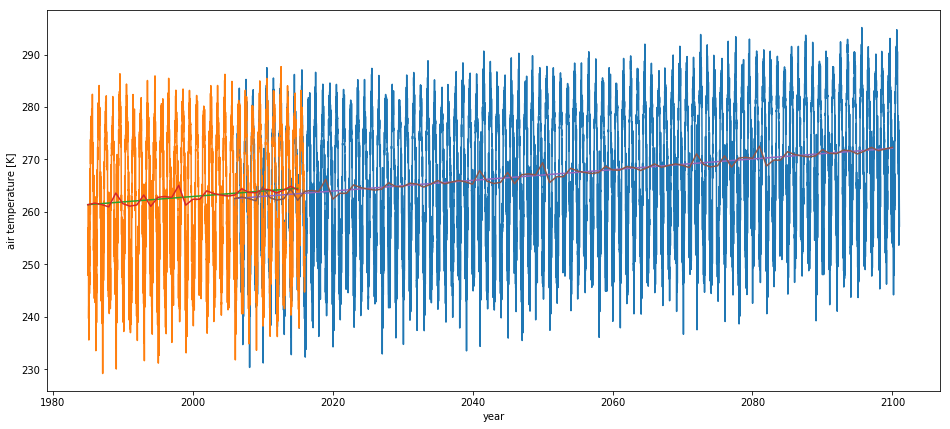

(230.3335063446717, 295.1525975020114)
Projecting: relative humidity [-]
(95, 365)


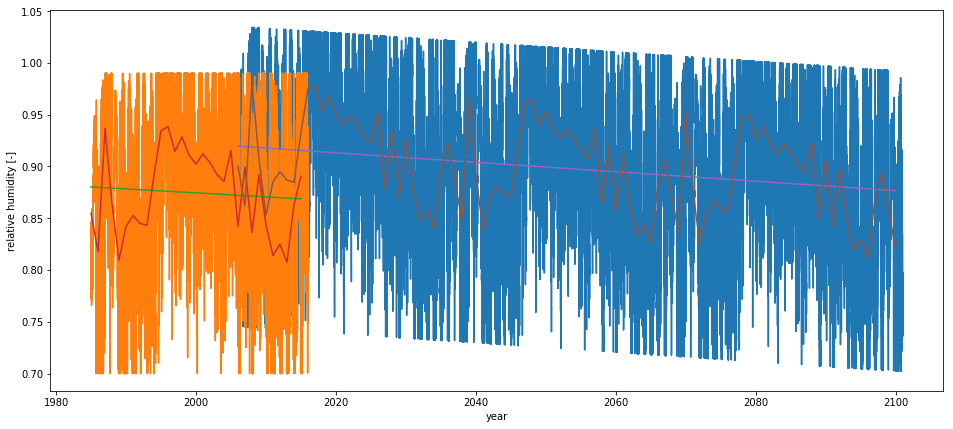

(0.702120383617496, 1.0342111533794212)
Projecting: incoming shortwave radiation [W m^-2]
(95, 365)


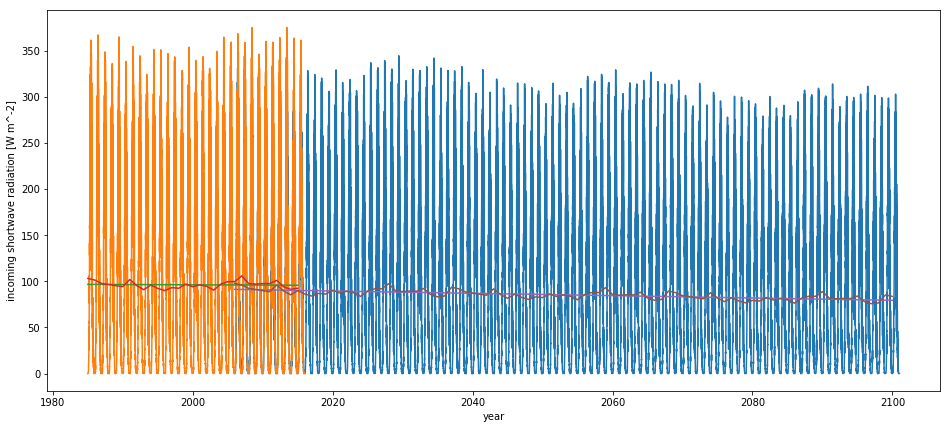

(0.0, 347.6587892859232)


In [27]:
# use CESM RCP8.5 air temperatures, RH, and incoming SW
proj[k_T] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_T], normalization[k_T], k_T, operator='additive')
proj[k_RH] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_RH], normalization[k_RH], k_RH, operator='additive')
proj[k_qSW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qSW], normalization[k_qSW], k_qSW, operator='multiplicative')

# uh oh, need to filter RH

In [28]:
def filter(dat, min_val, max_val, policy='avg'):
    if policy == 'clip':
        dat = np.where(dat > max_val, max_val, dat)
        dat = np.where(dat < min_val, min_val, dat)
        return dat
    elif policy == 'avg':
        bad_high = np.where(dat > max_val)[0]
        for bh in bad_high:
            bh_l = bh - 1
            while bh_l in bad_high:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_high:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2.

        bad_low = np.where(dat < min_val)[0]
        for bh in bad_low:
            bh_l = bh - 1
            while bh_l in bad_low:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_low:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2. 
        return dat
    else:
        raise RuntimeError('Policy must be "avg" or "clip"')



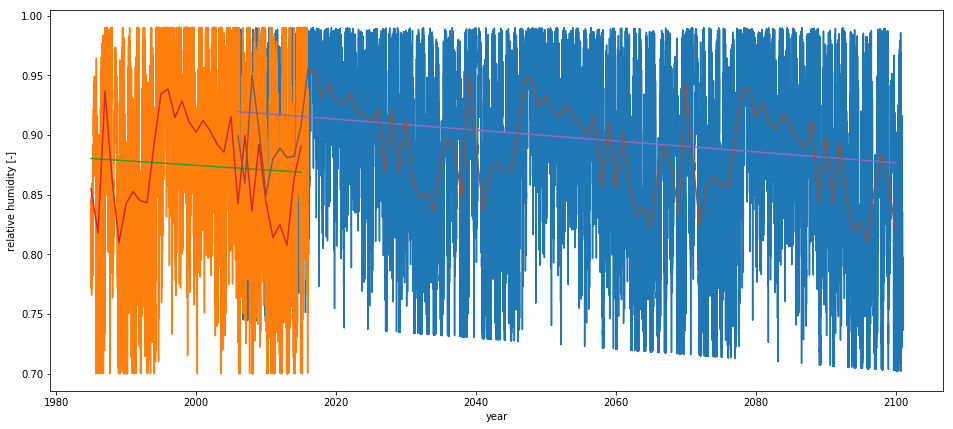

In [29]:
# filter RH
shp = proj[k_RH].shape
proj[k_RH] = filter(proj[k_RH].ravel(), 0.5, 0.99, 'avg').reshape(shp)

plot(year_c, proj[k_RH], poly_trends['CESM RCP8.5'][k_RH], k_RH)


(0.001, 17.378125)
(0.001, 17.378125)


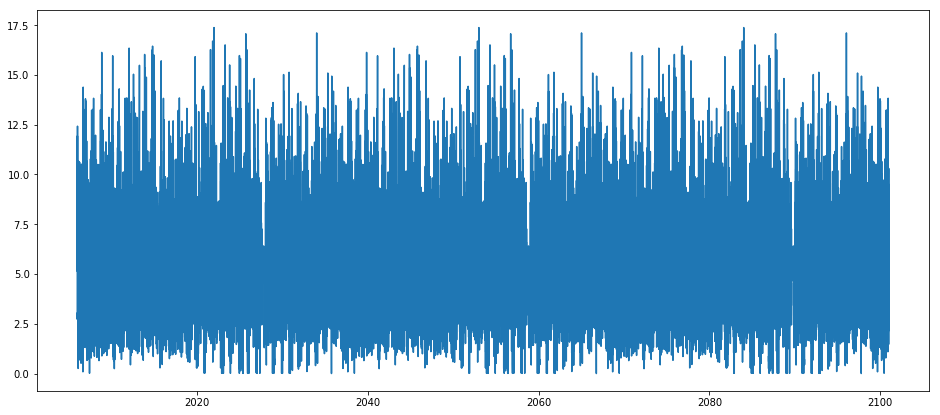

In [31]:
# just cycle wind speed
proj[k_U] = np.array([d for i,d in zip(range(len(year_c)), year_generator(daymet[k_U]))])
plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_U].ravel())

print(daymet[k_U].min(), daymet[k_U].max())
print(proj[k_U].min(), proj[k_U].max())

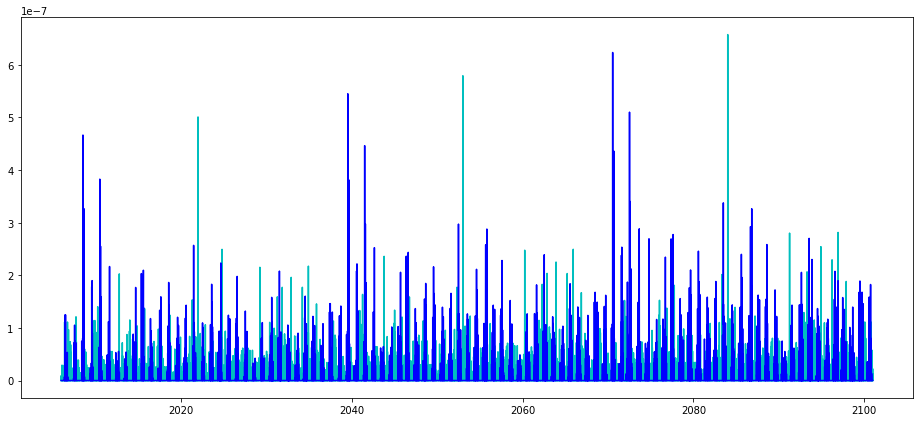

In [34]:
# partition rain
#precip = proj.pop(k_P)
proj[k_Ps] = np.where(proj[k_T] > 273.15, 0., precip)
proj[k_Pr] = np.where(proj[k_T] > 273.15, precip, 0)

plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Ps].ravel(), 'c')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Pr].ravel(), 'b')
plt.show()



In [35]:
# save to file
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
assert(len(times) == 365*95)

with h5py.File("projected-met-2006-2100.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        fout.create_dataset(k, data=proj[k].ravel())

    